In [1]:
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import time
import sys
import matplotlib.image as mpimg
import os
import copy
import torch.utils.data as torch_data
import matplotlib.pyplot as plt

In [2]:
class ResBlock(nn.Module):
    def __init__(self, norm_layer, in_channels, out_channels, down_sample=False):
        
        super(ResBlock, self).__init__()
        self.norm_layer = norm_layer
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if down_sample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = norm_layer(out_channels)
        self.bn2 = norm_layer(out_channels)
        
        if not self.in_channels == self.out_channels:
            self.proj = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=2)
    
    def forward(self, x):
        if self.in_channels == self.out_channels:
            return F.relu(x + self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        else:
            return F.relu(self.proj(x) + self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))

class ResNet(nn.Module):
    def __init__(self, n=2, embedding=False):
        
        super(ResNet, self).__init__()
        self.norm_layer = nn.BatchNorm2d
        self.embedding = embedding
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = self.norm_layer(16)
        
        layer1 = []
        for i in range(n):
            layer1.append(ResBlock(self.norm_layer, 16, 16))
        
        self.layer1 = nn.ModuleList(layer1)
        
        layer2 = []
        for i in range(n):
            if i == 0:
                layer2.append(ResBlock(self.norm_layer, 16, 32, down_sample=True))
            else:
                layer2.append(ResBlock(self.norm_layer, 32, 32))
        self.layer2 = nn.ModuleList(layer2)
        
        layer3 = []
        for i in range(n):
            if i == 0:
                layer3.append(ResBlock(self.norm_layer, 32, 64, down_sample=True))
            else:
                layer3.append(ResBlock(self.norm_layer, 64, 64))
        self.layer3 = nn.ModuleList(layer3)
        
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, 2)
        #self.fc = nn.Linear(64, 10) We will use 5 heads for this purpose. 
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        for layer in self.layer1:
            x = layer(x)
        
        for layer in self.layer2:
            x = layer(x)
        
        for layer in self.layer3:
            x = layer(x)
            
        x = self.pooling(x)
        x = x.flatten(start_dim=1) 
        
        if self.embedding:
            return x
        else:
            x = self.fc(x)
            return x

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet, self).__init__()
        self.resnet_zero = ResNet(embedding=False)
        self.resnet_other = ResNet(embedding=True)
        self.margin = torch.tensor(2)
        self.margin.requires_grad = False
    
    def criterion_other(self, a, p, n):
        fa = torch.sigmoid(self.resnet_other(a))
        fp = torch.sigmoid(self.resnet_other(p))
        fn = torch.sigmoid(self.resnet_other(n))
        fa_fp = fa - fp
        fa_fn = fa - fn
        
        loss = torch.clamp((fa_fp * fa_fp).sum(dim=1) + self.margin - (fa_fn * fa_fn).sum(dim=1), min=0)
        return loss.mean()
    
    def forward(self, x):
        return self.resnet_zero(x)

In [4]:
class DigitDataset(torch_data.Dataset):
    def __init__(self):
        transform = transforms.Compose([transforms.ToTensor()])
        self.target = torch.load('Assignment 2/visual_sudoku/target.pt')
        #self.zeros = torch.load('Assignment 2/visual_sudoku/zeros.pt')
        self.augment = transforms.Compose([transforms.ToPILImage(),
                             transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(1.2,1.2)),
                             transforms.ToTensor()
                            ])
    
    def __len__(self):
        #return 14 * self.target.shape[0] 
        return 14 * int(self.target.shape[0] * 1/2) 
    
    def __getitem__(self, S):
        
        #if S < 14 * self.target.shape[0]:
        i, j = S // 14, S % 14
        image = self.target[i]

        if j < 7:
            idx = 8 * (i // 8) + (i + j + 1) % 8
        else:
            idx = 64 * (i // 64) + (i + 8 * (j - 6)) % 64

        negative = self.target[idx]
        return image.unsqueeze(0), self.augment(image), negative.unsqueeze(0)
        #else:
        #    i = S - 14 * self.target.shape[0]
        #    image = self.zeros[i]
            
        #    return image.unsqueeze(0), self.augment(image), self.target[i].unsqueeze(0)
        #if S < self.target.shape[0]:
        #    img = self.target[S]
        #    next_idx = 8 * (S // 8) + (S + 1) % 8
        #    next_img = self.target[next_idx]
            #print(img.shape, self.augment(img).shape, next_img.shape)
        #    return img.unsqueeze(0), self.augment(img), next_img.unsqueeze(0)
        #else:
        #    i = S - self.target.shape[0]
            #print(self.zeros[i], self.augment(self.zeros[i]).shape, self.augment(self.target[i]).shape)
        #    return self.zeros[i].unsqueeze(0), self.augment(self.zeros[i]), self.augment(self.target[i])

class ZeroDataset(torch_data.Dataset):
    def __init__(self):
        transform = transforms.Compose([transforms.ToTensor()])
        self.zeros = torch.load('data/pt-cache/zeros.pt')
        self.target = torch.load('data/pt-cache/target.pt')
    
    def __len__(self):
        return self.zeros.shape[0] + self.target.shape[0]
    
    def __getitem__(self, i):
        if i < self.zeros.shape[0]:
            return self.zeros[i].unsqueeze(0), torch.tensor(0)
        else:
            return self.target[i - self.zeros.shape[0]].unsqueeze(0), torch.tensor(1)
        

In [5]:
digit_dataset = DigitDataset()
zero_dataset = ZeroDataset()

FileNotFoundError: [Errno 2] No such file or directory: 'Assignment 2/visual_sudoku/target.pt'

In [83]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')    
print(device)
print(len(digit_dataset), len(zero_dataset))
net = Triplet().to(device)

cuda
4480000 956415


In [8]:
import time 
import tqdm as tqdm
tic = time.time()
optimizer = optim.Adam(net.parameters(), lr=3e-4,)
criterion = nn.CrossEntropyLoss()

split = int(0.95 * len(zero_dataset))
zero_train, zero_val = torch.utils.data.random_split(zero_dataset, [split, len(zero_dataset) - split])

print("train size:", len(zero_train))
print("val size:", len(zero_val))

trainloader = torch.utils.data.DataLoader(zero_train, batch_size=512, shuffle=True)
running_loss = 0.0
for epoch in range(3):
    net.train()
    print("Starting epoch " + str(epoch) + ", time: ", time.time() - tic)
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        pred = net(images)
        loss = criterion(pred, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10 == 9:
            print("epoch: ", epoch + 1, "iter: ", i + 1, "loss: ", running_loss / 10, "time: ", time.time() - tic)
            running_loss = 0
            
        if i == 100:
            break
    running_loss = 0.0
    
    net.eval()
    with torch.no_grad():
        actual, prediction = [], []
        valloader = torch.utils.data.DataLoader(zero_val, batch_size=512, shuffle=False)
        for val_epoch in range(1):
            for i, data in enumerate(valloader, 0):
                optimizer.zero_grad()
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                pred = net(images)
                
                actual.extend(labels.squeeze().tolist())
                prediction.extend(torch.argmax(pred, dim=1).squeeze().tolist())
                
                if i % 10 == 0:
                    print("Evaluating:", i)
        print(len(actual), len(prediction))
        print(accuracy_score(actual, prediction))
                
                


        

train size: 908594
val size: 47821
Starting epoch 0, time:  0.10975050926208496
epoch:  1 iter:  10 loss:  0.4047797530889511 time:  2.766765832901001
epoch:  1 iter:  20 loss:  0.19175941944122316 time:  4.248536586761475
epoch:  1 iter:  30 loss:  0.11447128728032112 time:  5.7300426959991455
epoch:  1 iter:  40 loss:  0.07890605106949806 time:  7.211262464523315
epoch:  1 iter:  50 loss:  0.05223602578043938 time:  8.692730903625488
epoch:  1 iter:  60 loss:  0.03605915475636721 time:  10.261943578720093
epoch:  1 iter:  70 loss:  0.0280012097209692 time:  11.74402642250061
epoch:  1 iter:  80 loss:  0.024044165574014186 time:  13.22484827041626
epoch:  1 iter:  90 loss:  0.019113270472735165 time:  14.704186201095581
epoch:  1 iter:  100 loss:  0.014198832307010889 time:  16.185583353042603
Evaluating: 0
Evaluating: 10
Evaluating: 20
Evaluating: 30
Evaluating: 40
Evaluating: 50
Evaluating: 60
Evaluating: 70
Evaluating: 80
Evaluating: 90
47821 47821
0.9993935718617344
Starting epoch

In [74]:
def constraint_violation(sudoku):
    for i in range(8):
        a = set()
        for j in range(8):
            elem = sudoku[i][j].item()
            a.add(elem)
        #print("row", a)
        if not len(a) == 8:
            return True

    for i in range(8):
        a = set()
        for j in range(8):
            elem = sudoku[j][i].item()
            a.add(elem)
        #print("col", a)
        if not len(a) == 8:
            return True

    for i in range(0, 8, 2):
        for j in range(0, 8, 4):
            a = set()
            for x in range(0, 2):
                for y in range(0, 4):
                    elem = sudoku[i + x][j + y].item()
                    a.add(elem)
            #print("block", a)      
            if not len(a) == 8:
                return True
    return False

In [84]:
import time 
import tqdm as tqdm
tic = time.time()
optimizer = optim.Adam(net.parameters(), lr=1e-4,)

dataloader = torch.utils.data.DataLoader(digit_dataset, batch_size=512, shuffle=True)
running_loss = 0.0
for epoch in range(1):
    print("Starting epoch " + str(epoch) + ", time: ", time.time() - tic)
    for i, data in enumerate(dataloader, 0):
        net.train()
        optimizer.zero_grad()
        anchor, positive, negative = data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        loss = net.criterion_other(anchor, positive, negative)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10 == 9:
            print("epoch: ", epoch + 1, "iter: ", i + 1, "loss: ", running_loss / 10, "time: ", time.time() - tic)
            running_loss = 0
            
        if i % 100 == 0:
            net.eval()
            with torch.no_grad():
                prediction = []
                truths = torch.empty(8, 64)
                samples = np.load('Assignment 2/sample_images.npy') / 255.0
                for i in range(1, 9):
                    sample_t = torch.from_numpy(samples[i])
                    truths[i - 1] = torch.sigmoid(net.resnet_other(sample_t.unsqueeze(0).unsqueeze(0).float().to(device)))
                
                query = Query()
                queryloader = torch.utils.data.DataLoader(query, batch_size=512, shuffle=False)
                prediction = []

                for i, data in enumerate(queryloader):
                    data = data.to(device)

                    act = torch.sigmoid(net.resnet_other(data)).unsqueeze(0)
                    gt = truths.unsqueeze(1).cuda()

                    diff = act - gt
                    diffnorm = diff.norm(dim=2)
                    pred = diffnorm.argmin(0)
                    pred = pred + 1
                    #print(gt.shape, act.shape, diff.shape, diffnorm.shape, pred.shape)
                    prediction.extend(pred.tolist())
                
                

                violations = 0
                print(prediction[0:64])
                for i in range(1, 10000):
                    tp = torch.tensor(prediction[i * 64: (i + 1) * 64])
                    tp = tp.reshape(8, 8)


                    if constraint_violation(tp):
                        violations += 1

                    #if violation:
                    #    v_i.append((i, diff.long() * qp))
                    #    violations += 1


                print(violations)
            
        
    running_loss = 0.0
        

Starting epoch 0, time:  0.1396501064300537
[7, 1, 8, 4, 2, 1, 7, 2, 7, 8, 1, 4, 4, 1, 1, 8, 8, 1, 8, 8, 1, 3, 1, 7, 3, 7, 8, 1, 8, 8, 2, 1, 7, 1, 7, 1, 2, 8, 8, 7, 1, 1, 3, 2, 8, 4, 8, 3, 7, 3, 1, 1, 7, 2, 8, 8, 8, 4, 8, 7, 6, 8, 1, 5]
9999
epoch:  1 iter:  10 loss:  1.8753560304641723 time:  58.954389333724976
epoch:  1 iter:  20 loss:  1.4893868923187257 time:  64.53934359550476
epoch:  1 iter:  30 loss:  1.2887802481651307 time:  70.1160523891449
epoch:  1 iter:  40 loss:  1.208349871635437 time:  75.70428991317749
epoch:  1 iter:  50 loss:  1.1435859084129334 time:  81.29783487319946
epoch:  1 iter:  60 loss:  1.0711726069450378 time:  86.87880373001099
epoch:  1 iter:  70 loss:  1.031132698059082 time:  92.45588707923889
epoch:  1 iter:  80 loss:  1.0018381357192994 time:  98.05665063858032
epoch:  1 iter:  90 loss:  0.9274885475635528 time:  103.64226508140564
epoch:  1 iter:  100 loss:  0.9038568377494812 time:  109.21795558929443
[5, 3, 8, 2, 6, 2, 3, 4, 6, 4, 2, 3, 1, 6, 2, 8

KeyboardInterrupt: 

(10, 28, 28)


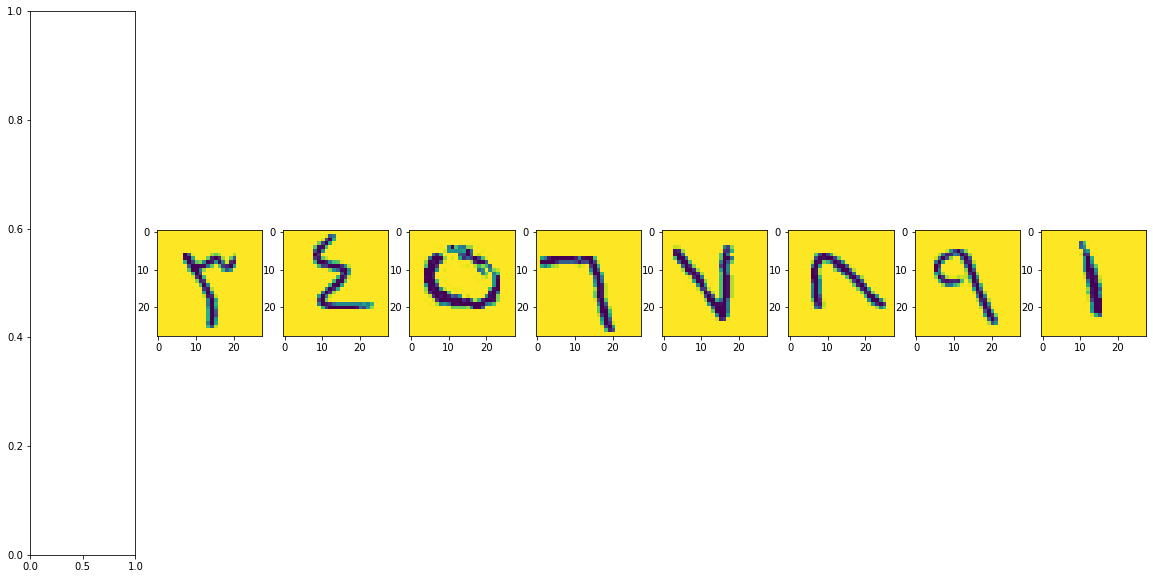

In [54]:
net.eval()
with torch.no_grad():
    
    truths = torch.empty(8, 64)
    samples = np.load('Assignment 2/sample_images.npy') / 255.0
    print(samples.shape)
    fig, ax = plt.subplots(1, 9, figsize=(20,10))
    for i in range(1, 9):
        ax[i].imshow(samples[i])
        sample_t = torch.from_numpy(samples[i])
        truths[i - 1] = torch.sigmoid(net.resnet_other(sample_t.unsqueeze(0).unsqueeze(0).float().cuda()))

    #plt.imshow(samples[0].squeeze())
    #for i in range(1, 2):
    #    a, b, c = dataset.__getitem__(i)
    #    print(a.norm(), b.norm(), c.norm())
    #    print(net.criterion(a.unsqueeze(0).cuda(), b.unsqueeze(0).cuda(), c.unsqueeze(0).cuda()))
    #    a, b, c = torch.sigmoid(net.resnet(a.unsqueeze(0).cuda())), torch.sigmoid(net.resnet(b.unsqueeze(0).cuda())), torch.sigmoid(net.resnet(c.unsqueeze(0).cuda()))

    #    print(a, b, c)
    #    print((a - c).norm(), (a - b).norm())

    #dataloader = torch.utils.data.DataLoader(dataset, batch_size=12, shuffle=False)
    #for epoch in range(1):
    #    print("Starting epoch " + str(epoch) + ", time: ", time.time() - tic)
    #    for i, data in enumerate(dataloader, 0):

    #        anchor, positive, negative = data
    #        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
    #        loss = net.criterion(anchor, positive, negative, verbose=True)
    #        print(loss)
    #        if i == 0:
    #            break

In [49]:
class Query(torch_data.Dataset):
    def __init__(self):
        self.query = torch.load('Assignment 2/visual_sudoku/target.pt')
    
    def __len__(self):
        return self.query.shape[0]
    
    def __getitem__(self, S):
        
        return self.query[S].unsqueeze(0)

In [55]:
net.eval()

query = Query()
queryloader = torch.utils.data.DataLoader(query, batch_size=512, shuffle=False)
prediction = []

target = True

with torch.no_grad():
    for i, data in enumerate(queryloader):
        data = data.to(device)
        
        if target:
            act = torch.sigmoid(net.resnet_other(data)).unsqueeze(0)
            gt = truths.unsqueeze(1).cuda()

            diff = act - gt
            diffnorm = diff.norm(dim=2)
            pred = diffnorm.argmin(0)
            pred = pred + 1
            #print(gt.shape, act.shape, diff.shape, diffnorm.shape, pred.shape)
            prediction.extend(pred.tolist())
        else:
            z = net.resnet_zero(data)
            z = z.argmax(dim=1)
            act = torch.sigmoid(net.resnet_other(data)).unsqueeze(0)
            
            diff = act - gt
            diffnorm = diff.norm(dim=2)
            pred = diffnorm.argmin(0)
            
            pred = z + z * pred
            prediction.extend(pred.tolist())
            
        if i % 100 == 0:
            print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [56]:
print(prediction[0:64])

[6, 5, 8, 4, 7, 1, 3, 2, 2, 1, 7, 3, 4, 5, 6, 8, 1, 4, 2, 8, 6, 3, 5, 7, 3, 7, 5, 6, 8, 4, 2, 1, 5, 6, 1, 7, 2, 8, 4, 3, 4, 8, 3, 2, 1, 6, 7, 5, 7, 3, 6, 1, 5, 2, 8, 4, 8, 2, 4, 5, 3, 7, 1, 6]


In [57]:
violations = 0
v_i = []

def constraint_violation(sudoku):
    for i in range(8):
        a = set()
        for j in range(8):
            elem = sudoku[i][j].item()
            a.add(elem)
        #print("row", a)
        if not len(a) == 8:
            return True
        
    for i in range(8):
        a = set()
        for j in range(8):
            elem = sudoku[j][i].item()
            a.add(elem)
        #print("col", a)
        if not len(a) == 8:
            return True
    
    for i in range(0, 8, 2):
        for j in range(0, 8, 4):
            a = set()
            for x in range(0, 2):
                for y in range(0, 4):
                    elem = sudoku[i + x][j + y].item()
                    a.add(elem)
            #print("block", a)      
            if not len(a) == 8:
                return True
    return False

violations = 0
for i in range(1, 10000):
    tp = torch.tensor(prediction[i * 64: (i + 1) * 64])
    tp = tp.reshape(8, 8)
    
    
    if constraint_violation(tp):
        violations += 1
    
    #if violation:
    #    v_i.append((i, diff.long() * qp))
    #    violations += 1
    

print(violations)

2747


In [27]:
torch.save(net.state_dict(), 'triplet.pt')

In [26]:
torch.save(prediction, 'Assignment 2/visual_sudoku/query_pred.pt')

In [28]:
print(prediction[64:127])

[0, 0, 0, 1, 0, 0, 5, 7, 0, 5, 0, 0, 3, 0, 0, 0, 1, 0, 5, 4, 7, 6, 2, 0, 0, 0, 0, 2, 0, 8, 4, 0, 2, 7, 8, 5, 6, 3, 1, 0, 0, 1, 0, 3, 8, 5, 7, 2, 0, 0, 3, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0]


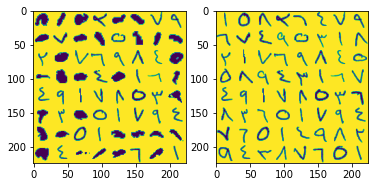

In [31]:
fig, ax = plt.subplots(1, 2)
a = mpimg.imread('Assignment 2/visual_sudoku/train/query/1.png')
ax[0].imshow(a)
a = mpimg.imread('Assignment 2/visual_sudoku/train/target/1.png')
ax[1].imshow(a)